## No se observa la estructura normal descrita en la documentacion de Tweeter
- No se encuentra retweet_status 
- No se observa screen_name
- No se observa presencia de el tag entities

In [8]:
import os
import string
import pandas as pd

import json
from collections import Counter
import re
from glob import glob
from datetime import datetime
from matplotlib import pyplot as plt
from time import gmtime, mktime, strptime
import missingno as msng
import seaborn as sns
from fastavro import writer, reader, schema
from rec_avro import to_rec_avro_destructive, from_rec_avro_destructive, rec_avro_schema
from pandas.api.types import CategoricalDtype

In [39]:
## Convierte json_obj a avro_file
def turntoavro(data):
    avro_objects = [to_rec_avro_destructive(data)]
    with open('json_to_avro.avro', 'a+b') as f_out:
        writer(f_out, schema.parse_schema(rec_avro_schema()), avro_objects)

## Load json file
 - Como mejora, este proceso podría ir en un ciclo que recorra cada uno de los posibles archivos que contengan tweets

In [10]:
DIR = 'C:/Users/gufernandez/Documents/tweets.json/farmers-protest-tweets-2021-2-4.json'

### Etapa exploratoria de los datos
 - Lectura full json
 - No se encuentra el tag entientes, desde donde se obtienen los hashtag de un tweet
 - No se encuentra el tag retweet_status, desde donde se puede inferir si un tweet es retweet o no

In [11]:
tweets = pd.read_json(DIR, lines=True)
tweets.head(1)

,url,date,content,renderedContent,id,user,outlinks,tcooutlinks,replyCount,retweetCount,...,quoteCount,conversationId,lang,source,sourceUrl,sourceLabel,media,retweetedTweet,quotedTweet,mentionedUsers
0,https://twitter.com/ArjunSinghPanam/status/136...,2021-02-24 09:23:35+00:00,The world progresses while the Indian police a...,The world progresses while the Indian police a...,1364506249291784198,"{'username': 'ArjunSinghPanam', 'displayname':...",[https://twitter.com/ravisinghka/status/136415...,[https://t.co/es3kn0IQAF],0,0,...,0,1364506249291784198,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,None,NaN,{'url': 'https://twitter.com/RaviSinghKA/statu...,"[{'username': 'narendramodi', 'displayname': '..."


In [12]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117407 entries, 0 to 117406
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   url              117407 non-null  object             
 1   date             117407 non-null  datetime64[ns, UTC]
 2   content          117407 non-null  object             
 3   renderedContent  117407 non-null  object             
 4   id               117407 non-null  int64              
 5   user             117407 non-null  object             
 6   outlinks         117407 non-null  object             
 7   tcooutlinks      117407 non-null  object             
 8   replyCount       117407 non-null  int64              
 9   retweetCount     117407 non-null  int64              
 10  likeCount        117407 non-null  int64              
 11  quoteCount       117407 non-null  int64              
 12  conversationId   117407 non-null  int64              
 13 

<AxesSubplot:>

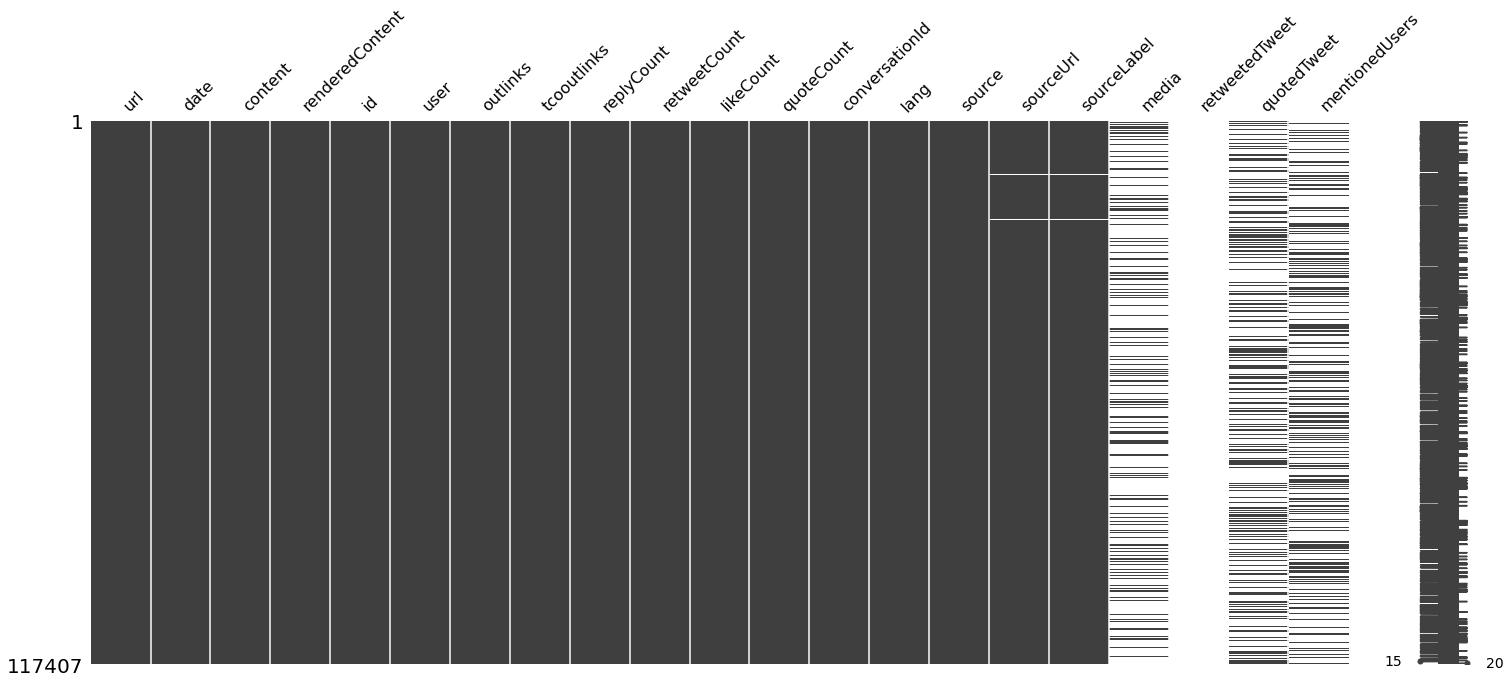

In [13]:
msng.matrix(tweets)

In [14]:
tweets.describe()

,id,replyCount,retweetCount,likeCount,quoteCount,conversationId,retweetedTweet
count,1.174070e+05,117407.000000,117407.000000,117407.000000,117407.000000,1.174070e+05,0.0
mean,1.362062e+18,0.631410,5.045619,14.609674,0.336241,1.361764e+18,NaN
std,1.293803e+15,9.436159,58.237370,229.083983,4.474576,1.294352e+16,NaN
min,1.360040e+18,0.000000,0.000000,0.000000,0.000000,1.981606e+10,NaN
25%,1.360935e+18,0.000000,0.000000,0.000000,0.000000,1.360887e+18,NaN
50%,1.361945e+18,0.000000,0.000000,1.000000,0.000000,1.361914e+18,NaN
75%,1.363097e+18,0.000000,1.000000,2.000000,0.000000,1.363068e+18,NaN
max,1.364506e+18,1291.000000,7723.000000,27888.000000,756.000000,1.364506e+18,NaN


## Incorporación de columnas adicionales
- Se agregaron las columnas:
    * usaername: usuario que realizó el tweet
    * created: fecha de creación del tweet. Se debe mantener el formato completo ya que tweet pueden tener segundo o menos de diferencia unos de otros
    * hashtag: se generó una columna con los hashtags que se obtuvieron desde el tag 'content' mediante un loop

In [15]:
# Agrego columnas extraidas desde el user 
tweets['username'] = pd.DataFrame(tweets['user'].tolist(),columns = ['username'])
tweets['created'] = pd.DataFrame(tweets['user'].tolist(),columns = ['created'])
tweets['day_name'] = pd.to_datetime(tweets['created'], dayfirst=True).dt.day_name()
tweets['day'] = pd.to_datetime(tweets['created'], dayfirst=True).dt.day
tweets['year'] = pd.to_datetime(tweets['created'], dayfirst=True).dt.year
tweets['month'] = pd.to_datetime(tweets['created'], dayfirst=True).dt.month

In [16]:
tweets.head(1)

,url,date,content,renderedContent,id,user,outlinks,tcooutlinks,replyCount,retweetCount,...,media,retweetedTweet,quotedTweet,mentionedUsers,username,created,day_name,day,year,month
0,https://twitter.com/ArjunSinghPanam/status/136...,2021-02-24 09:23:35+00:00,The world progresses while the Indian police a...,The world progresses while the Indian police a...,1364506249291784198,"{'username': 'ArjunSinghPanam', 'displayname':...",[https://twitter.com/ravisinghka/status/136415...,[https://t.co/es3kn0IQAF],0,0,...,None,NaN,{'url': 'https://twitter.com/RaviSinghKA/statu...,"[{'username': 'narendramodi', 'displayname': '...",ArjunSinghPanam,2009-06-06T07:50:57+00:00,Saturday,6,2009,6


In [17]:
hashtag = []
for content in tweets['content'].to_list():
    
    content = str(content).lower()
    hashtag.append([x for x in re.split(r',|\n| ', str(content)) if x.startswith('#')])
    
tweets['hashtags'] = hashtag

# Hago drop de la columna user ya que no se requiere mas información que 'username' y 'created'
tweets = tweets.drop ('user',axis=1)

C:\Users\gufernandez\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


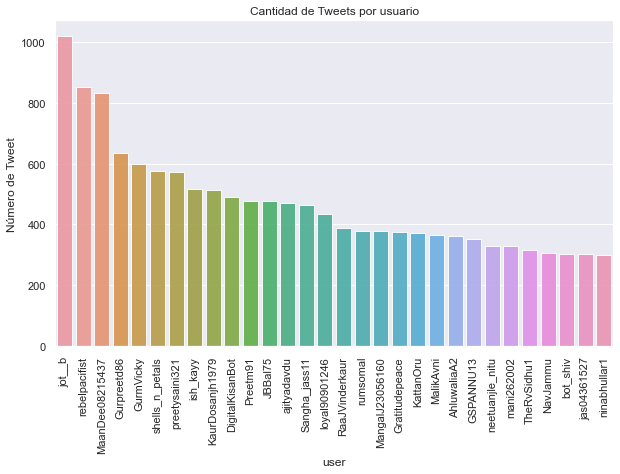

In [18]:
user_tweet_count = tweets['username'].value_counts().head(30)
plt.figure(figsize = (10,6))
sns.set(style="darkgrid")
sns.barplot(user_tweet_count.index, user_tweet_count.values, alpha=0.9)
plt.title('Cantidad de Tweets por usuario')
plt.ylabel('Número de Tweet', fontsize=12)
plt.xlabel('user', fontsize=12)
plt.xticks(rotation=90)
plt.show()

Text(0, 0.5, 'Número de Tweets')

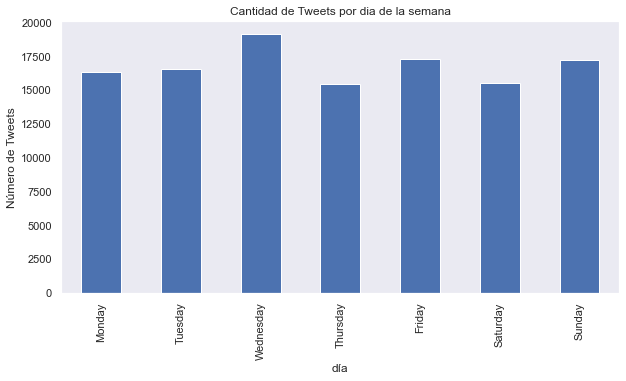

In [19]:
cats1 = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax = cat_type = pd.Categorical(tweets['day_name'],categories=cats1, ordered=True).value_counts().plot(kind='bar', grid=False, figsize=(10,5),title='Cantidad de Tweets por dia de la semana')
ax.set_xlabel("día")
ax.set_ylabel("Número de Tweets")

### 1 .- Obtenga cuales fueron los 10 tweets más retweeted y a que usuarios pertenecen esos tweets.
    - Se considera el tag 'content' como el tweet en sí para el despliegue de la solución
    - Utilizando la columna retweetCount como referencia se obtuvo el top 10 de tweets mas retweetiados

In [20]:
top_ten_retweet_user = tweets[['username','content','retweetCount']].sort_values(by='retweetCount', ascending=False)

In [21]:
# Resultado esperado para objetivo_1
top_ten_retweet_user.iloc[0:10]

,username,content,retweetCount
111329,RakeshTikaitBKU,मध्यप्रदेश में निजी व्यापारी 200 करोड़ का धान ...,7723
7645,dhruv_rathee,There's a #FarmersProtest happening in Germany...,6164
89780,rupikaur_,"disha ravi, a 21-year-old climate activist, ha...",4673
88911,amaanbali,Disha Ravi broke down in court room and told j...,3742
111556,jedijasmin_,Farmers are so sweet. Y’all have to see this @...,3332
64492,rupikaur_,india is targeting young women to silence diss...,3230
108072,RaviSinghKA,Bollywood has betrayed Panjab &amp; the farmer...,3182
60721,sherryontopp,लहरों को ख़ामोश देख कर ये ना समझना कि समंदर मे...,3057
29510,sherryontopp,"हाँ मैं जानता हूँ कि मैं शायर नहीं, और ज़ुल्म ...",3040
24160,sherryontopp,"कलियुग है साहब , यहाँ झूठे को स्वीकार किया जा...",2622


### 2.-  Los top 10 users en función a la cantidad de tweets que emitieron (no considerar retweets).
    - Tras la exploración realizada nos encontramos que el tag 'retweetedTweet' no contiene valores validos:
        *retweetedTweet   0 non-null por lo que se asume como parte de la solución la ausencia de un tag verificador de retweets

In [22]:
# genero el listado de 10 usuarios en funcion de los tweets emitidos. como value_counts esta ordenado solo extraigo los 10 primeros valores
top_ten_tweet_user = tweets[['username']].value_counts().reset_index().rename(columns={0: 'Counted_tweets'})
top_ten_tweet_user.iloc[0:10]

,username,Counted_tweets
0,jot__b,1019
1,rebelpacifist,850
2,MaanDee08215437,830
3,Gurpreetd86,636
4,GurmVicky,597
5,shells_n_petals,576
6,preetysaini321,573
7,ish_kayy,515
8,KaurDosanjh1979,512
9,DigitalKisanBot,490


## 3.- Obtenga los 10 días donde hay más tweets, muestre el día, la cantidad de tweets y todos los hastags que se usaron ese día
    - Se consideró un día valido en base a su etructura (año + mes + dia) ya que no se debe considerar la diferencia de horario para un mismo día. Por ende se realizó una transformación de la fecha,
    - Este punto consideró la utilización de un flujo loop y no otra opción, dado que solo son 10 dias los que se desean revisar. Como punto a mejorar es posible optimizar esta función para no recurrir a loop.

In [23]:
# Transformación de la fecha
tweets['created'] = tweets['created'].str.slice(0, 10)

# Extraigo el listado de dias que presentan la mayor cantidad de tweets
top_ten_tweet_by_day = tweets['created'].value_counts().reset_index().rename(columns={'index': 'date','created': 'tweet_count' })
top_ten_tweet_by_day = top_ten_tweet_by_day.iloc[0:10]

In [24]:
top_ten_tweet_by_day

,date,tweet_count
0,2020-11-29,3696
1,2020-12-01,3326
2,2020-12-03,2744
3,2020-12-02,2436
4,2020-12-04,2185
5,2020-11-30,2099
6,2021-02-03,1486
7,2021-02-04,1244
8,2021-01-30,1209
9,2021-01-27,1173


## 4.- Los top 10 hashtags más usados.
- Dado que son los primeros 10 elementos se utilizó un ciclo para presentar el resultado
- Se utilizò el paquete counter para realizar la estimacion de frecuencia de ocurrencia para los hashtags

In [25]:
hashtag_words = []
sum_elements = 0

for hashtag_list in tweets['hashtags']:
    hashtag_words +=(hashtag_list)   

# genero la lista del top 10 de hashtags mas usados
c = Counter(hashtag_words)

for i in c.most_common(10):
    print( "% s : % s" % (i), end ="\n")

#farmersprotest : 117010
#releasedetainedfarmers : 5960
#farmersmakeindia : 5300
#mahapanchayatrevolution : 4840
#repealonlywayahead : 4599
#indiabeingsilenced : 4476
#farmersprotests : 3730
#standwithfarmers : 3649
#pagdi_sambhal_jatta : 3537
#railrokoforfarmers : 3091


## 5.- Los top 10 users más influyentes en función de lo retweeted de sus tweets.
  - Se agrupo por el nombre de usuario y sumo la cantidad de retweets para cada uno de esos nombres
  - Recordar que el tag 'retweetedTweet' no está presente, que permite saber si un tweet es retweet o no y así omitirlos en este cálculo

In [26]:
# Obtengo como dataframe el listado de 10 usuarios mas influyentes
sumOfretweetCount = tweets.groupby(by=['username'], as_index=False)['retweetCount'].sum().sort_values(by=['retweetCount'], ascending=False)

In [27]:
sumOfretweetCount.iloc[0:10]

,username,retweetCount
16605,amaanbali,26354
24073,saahilmenghani,23288
12164,RaviSinghKA,22974
24724,sherryontopp,19175
11837,RakeshTikaitBKU,12001
24034,rupikaur_,11420
22538,news24tvchannel,10960
19566,iMani_KaurRai,10636
9532,Monica_Gill1,8593
17502,bhupenderc19,7360


## 6.- Guarde en un archivo avro todos los tweets para el hashtag #ReleaseDetainedFarmers entre el 2021-02-12 y 2021-02-24
    - Se almacenara como 'tweet' toda la información existente para dicho tweet. Lo que viene siendo la data cruda de este tweet

In [28]:
## Paquetes requeridos
!pip install avro
!pip3 install rec-avro
!pip install fastavro

In [29]:
# Obtengo el subser de tweets que se encuentran entre el '2021-02-12' y '2021-02-24'
subset_tweets_on_dates = tweets[(pd.to_datetime(tweets['created'])>=datetime.strptime('2021-02-12','%Y-%m-%d')) & (pd.to_datetime(tweets['created'])<=datetime.strptime('2021-02-24','%Y-%m-%d'))]

### Valido que el tag #releasedetainedfarmers se encuentre entre los tweet del subset

In [31]:
hashtag_words = []
sum_elements = 0

for hashtag_list in subset_tweets_on_dates['hashtags']:
    hashtag_words +=(hashtag_list)   

# genero la lista del top 10 de hashtags mas usados
c = Counter(hashtag_words)

for i in c.most_common(20):
    print( "% s : % s" % (i), end ="\n")

#farmersprotest : 981
#farmersmakeindia : 68
#india : 56
#kisaan : 52
#sfj : 51
#bengal : 51
#maharashtra : 51
#modi_rojgar_do : 47
#khalistan : 47
#pagdi_sambhal_jatta : 43
#farmersprotests : 34
#modi_rojgaar_दो : 30
#msplawforallcrops : 30
#farmers : 28
#volunteer4farmr : 28
#farmerschallenge : 26
#disharavi : 23
#releasedetainedfarmers : 23
#nofarmersnofood : 22
#istandwithfarmers : 21


### Genero el subset con los tweet que tienen el tag especificado y el rango de fecha correcto

In [32]:
index_list = []
for hashtag_list in subset_tweets_on_dates['hashtags']:
    if '#releasedetainedfarmers' in hashtag_list:
        index_list.append(True)
    else:
        index_list.append(False)

In [33]:
tweets = subset_tweets_on_dates.loc[index_list]

### Convierto el dataframe subset con el hashtag #releasedetainedfarmers a formato avro
    - Se requiere dropear algunas columnas que no tienen el formato json necesario

In [34]:
tweets = tweets.drop ('username',axis=1)
tweets = tweets.drop ('created',axis=1)
tweets = tweets.drop ('day_name',axis=1)
tweets = tweets.drop ('day',axis=1)
tweets = tweets.drop ('year',axis=1)
tweets = tweets.drop ('month',axis=1)
tweets = tweets.drop ('hashtags',axis=1)

In [41]:
### Exportar el subset a jsonn
tweets.to_json('subset_tweets_on_dates.json')
tweets_subset_on_dates = pd.read_json('subset_tweets_on_dates.json', lines=True)

### Genero el abro file utilizando el json exportado

In [42]:
try:
    turntoavro(tweets_subset_on_dates)
except:
    print("No existen tweets en el intervalo indicado para ese hashtag\n")